In [1]:
import matplotlib
import matplotlib.pyplot as plt
import skimage
import numpy as np

In [2]:
from skimage import exposure, io, img_as_float
from skimage.color import rgb2gray
from sklearn.feature_extraction import image

In [3]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio

In [4]:
from sklearn import svm
from sklearn.svm import LinearSVC

In [5]:
img = io.imread("data/Stephanie/hyp-right/Images/10929IBA1_0021_20190610.TIF")
grayscale = rgb2gray(img)

Estimated Gaussian noise standard deviation = 0.1202738865683039


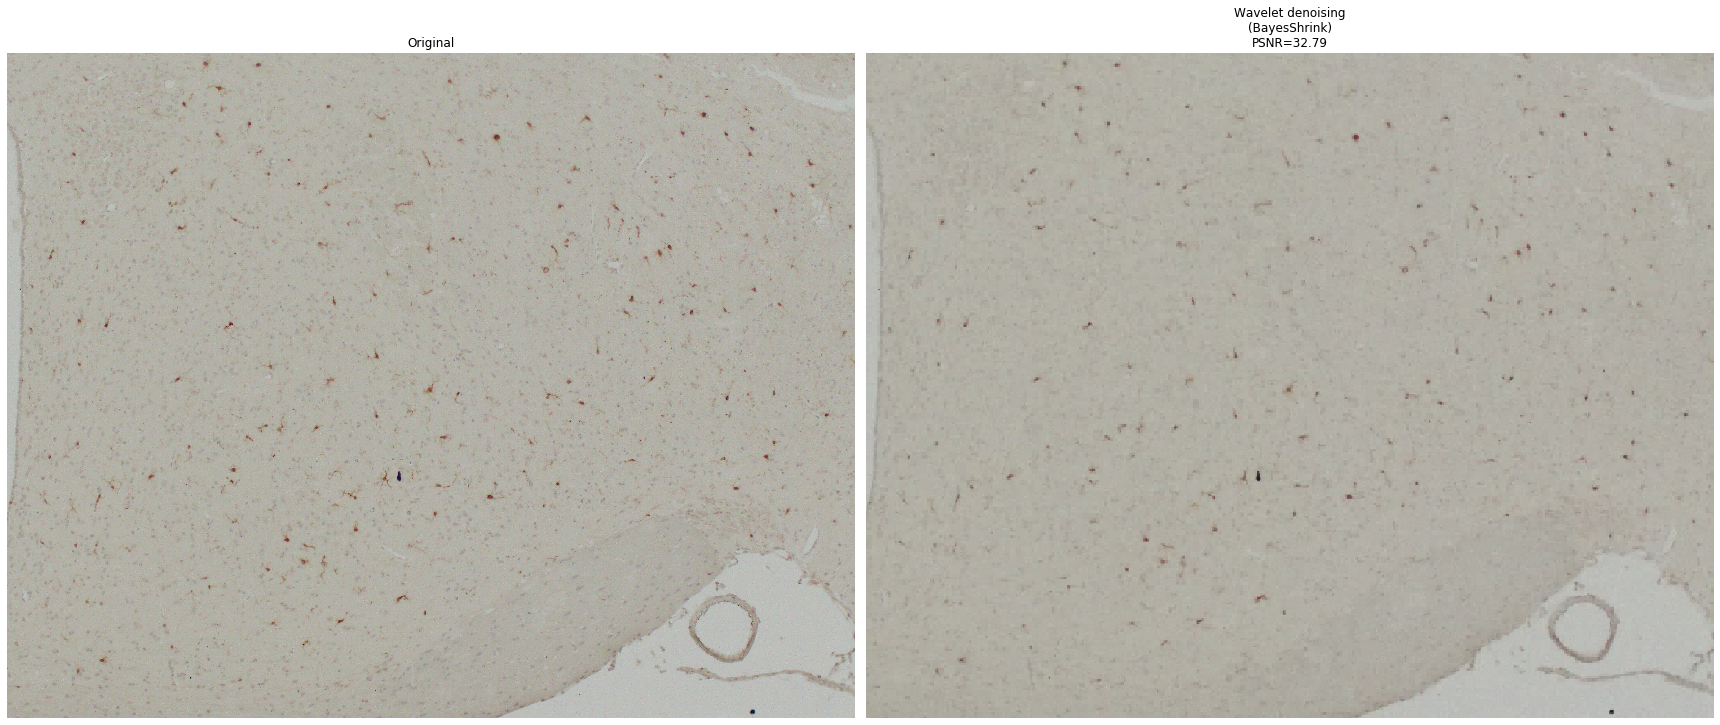

In [6]:
original = img_as_float(img)

sigma = 0.12
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

im_bayes = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)

# Compute PSNR as an indication of image quality
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)

ax[1].imshow(im_bayes)
ax[1].axis('off')
ax[1].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[0].imshow(original)
ax[0].axis('off')
ax[0].set_title('Original')
fig.tight_layout()

plt.show()

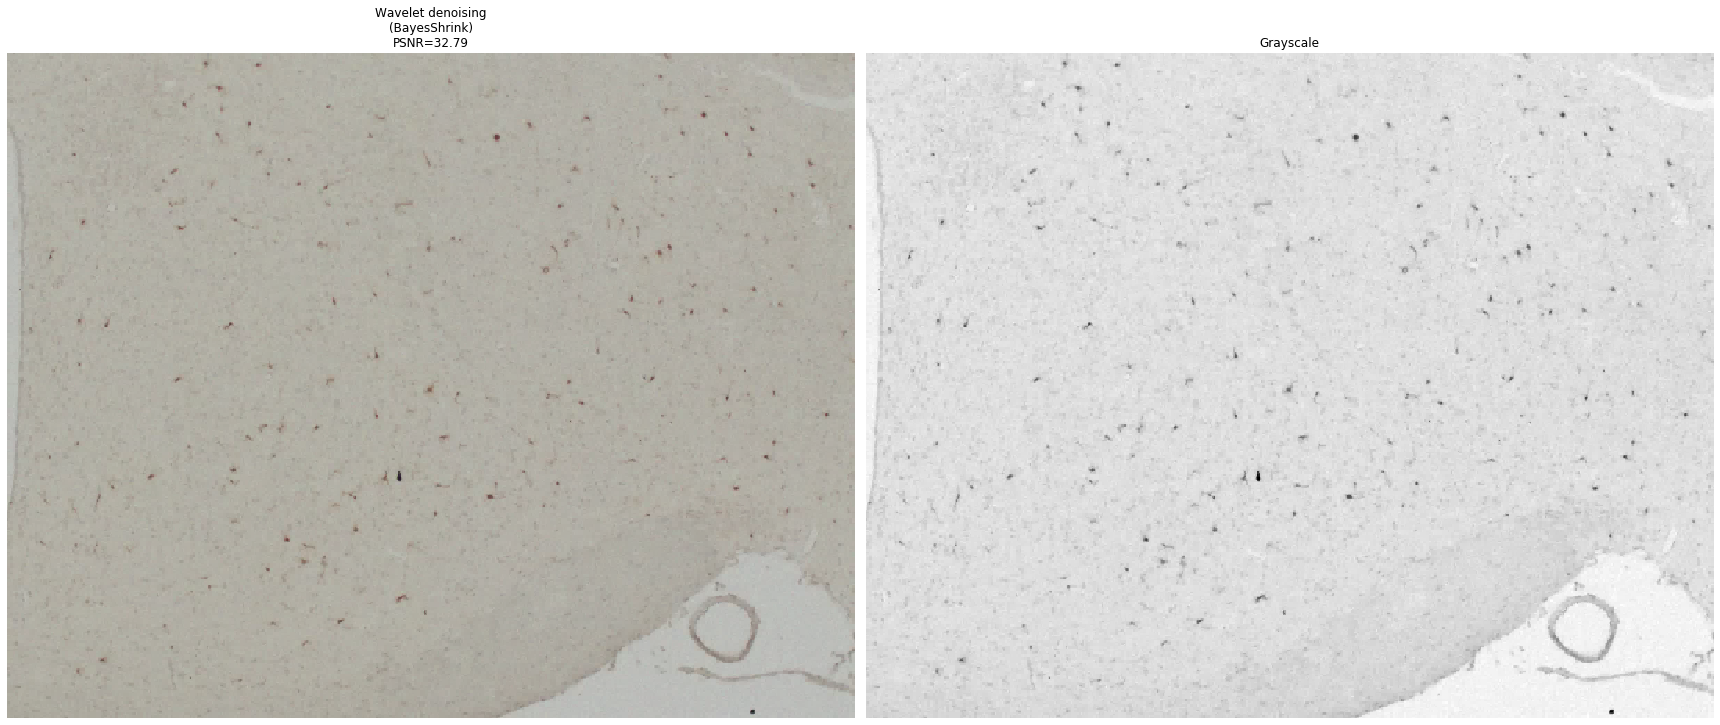

In [7]:
grayscale_bayes = rgb2gray(im_bayes)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(im_bayes)
ax[0].axis('off')
ax[0].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[1].imshow(grayscale_bayes)
ax[1].axis('off')
ax[1].set_title('Grayscale')
fig.tight_layout()

plt.show()

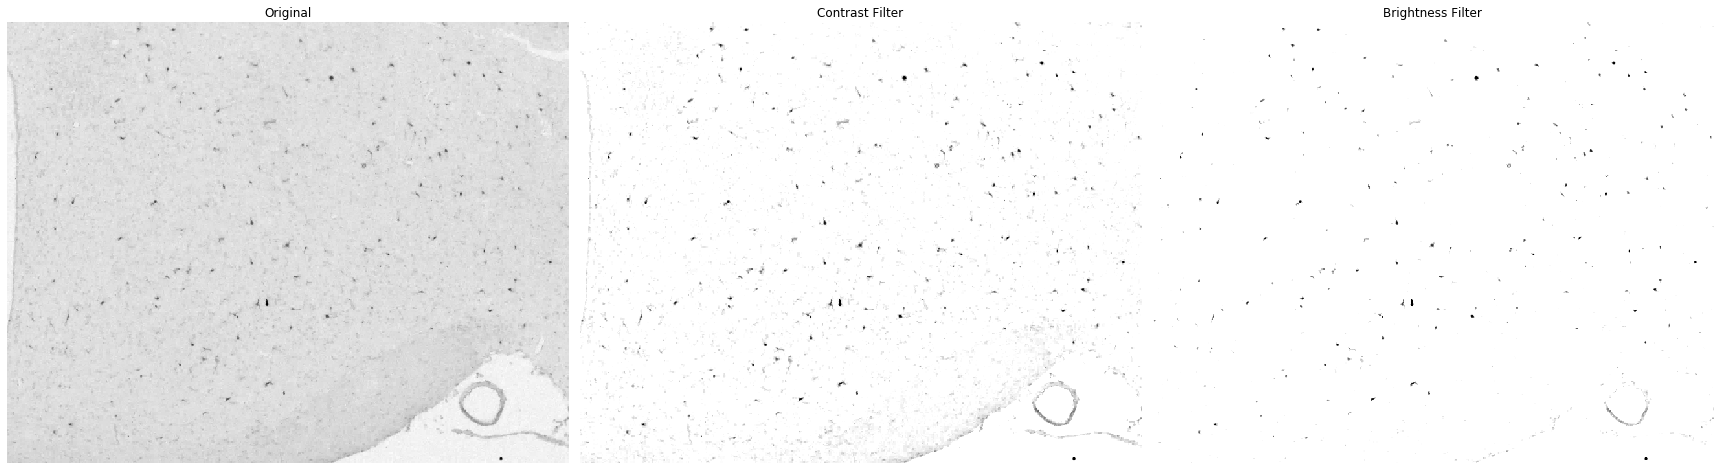

In [8]:
from PIL import Image, ImageEnhance
gscale = (grayscale_bayes * 255).astype(np.uint8)
img = Image.fromarray(gscale, mode = 'L')

brightener = ImageEnhance.Brightness(img)
bright_bayes_pil = brightener.enhance(1.5)

contrast = ImageEnhance.Contrast(bright_bayes_pil)
contrast_bayes = contrast.enhance(2)

brightener = ImageEnhance.Brightness(contrast_bayes)
bright_bayes_pil = brightener.enhance(1.2)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title(
    'Original'.format(psnr_bayes))
ax[2].imshow(bright_bayes_pil)
ax[2].axis('off')
ax[2].set_title('Brightness Filter')
ax[1].imshow(contrast_bayes)
ax[1].axis('off')
ax[1].set_title('Contrast Filter')
fig.tight_layout()

plt.show()

In [9]:
bright_bayes = np.array(bright_bayes_pil)

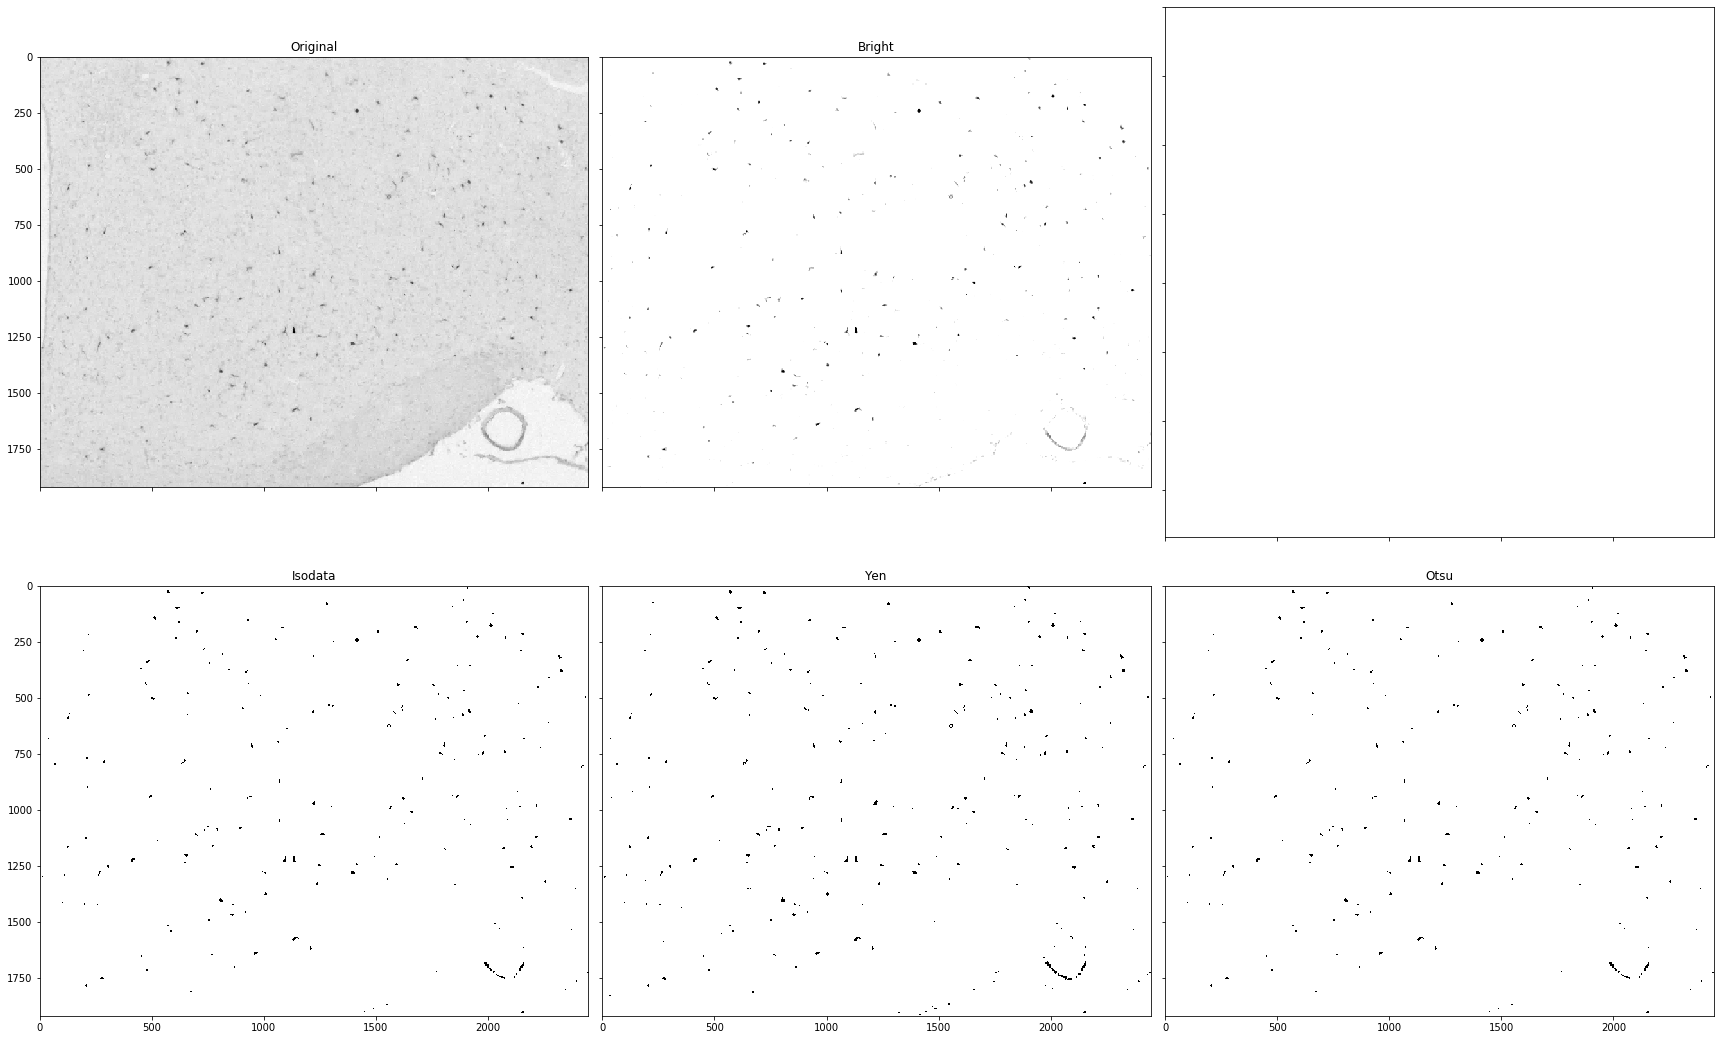

In [10]:
from skimage.filters import threshold_isodata, threshold_yen, threshold_otsu
thresh_iso = threshold_isodata(bright_bayes)
isodata = bright_bayes > thresh_iso

thresh_yen = threshold_yen(bright_bayes)
yen = bright_bayes > thresh_yen

thresh_otsu = threshold_otsu(bright_bayes)
otsu = bright_bayes > thresh_otsu

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0, 0].imshow(grayscale_bayes)
ax[0, 0].set_title(
    'Original'.format(psnr_bayes))
ax[0, 1].imshow(bright_bayes)
ax[0, 1].set_title(
    'Bright'.format(psnr_bayes))
ax[1, 0].imshow(isodata)
ax[1, 0].set_title(
    'Isodata'.format(psnr_bayes))
ax[1, 1].imshow(yen)
ax[1, 1].set_title(
    'Yen'.format(psnr_bayes))
ax[1,2].imshow(otsu)
ax[1,2].set_title('Otsu')
fig.tight_layout()

plt.show()

In [18]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [64]:
patches = blockshaped(isodata, 20, 18)
patches.shape

(13056, 20, 18)

In [65]:
goodPatches = []
for patch in patches:
    if False in patch:
        goodPatches.append(patch)
npPatches = np.array(goodPatches)

In [66]:
npPatches.shape

(351, 20, 18)

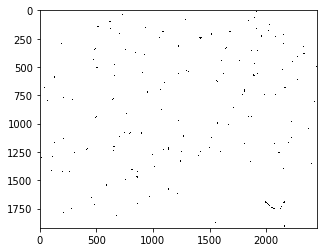

In [68]:
plt.imshow(isodata)

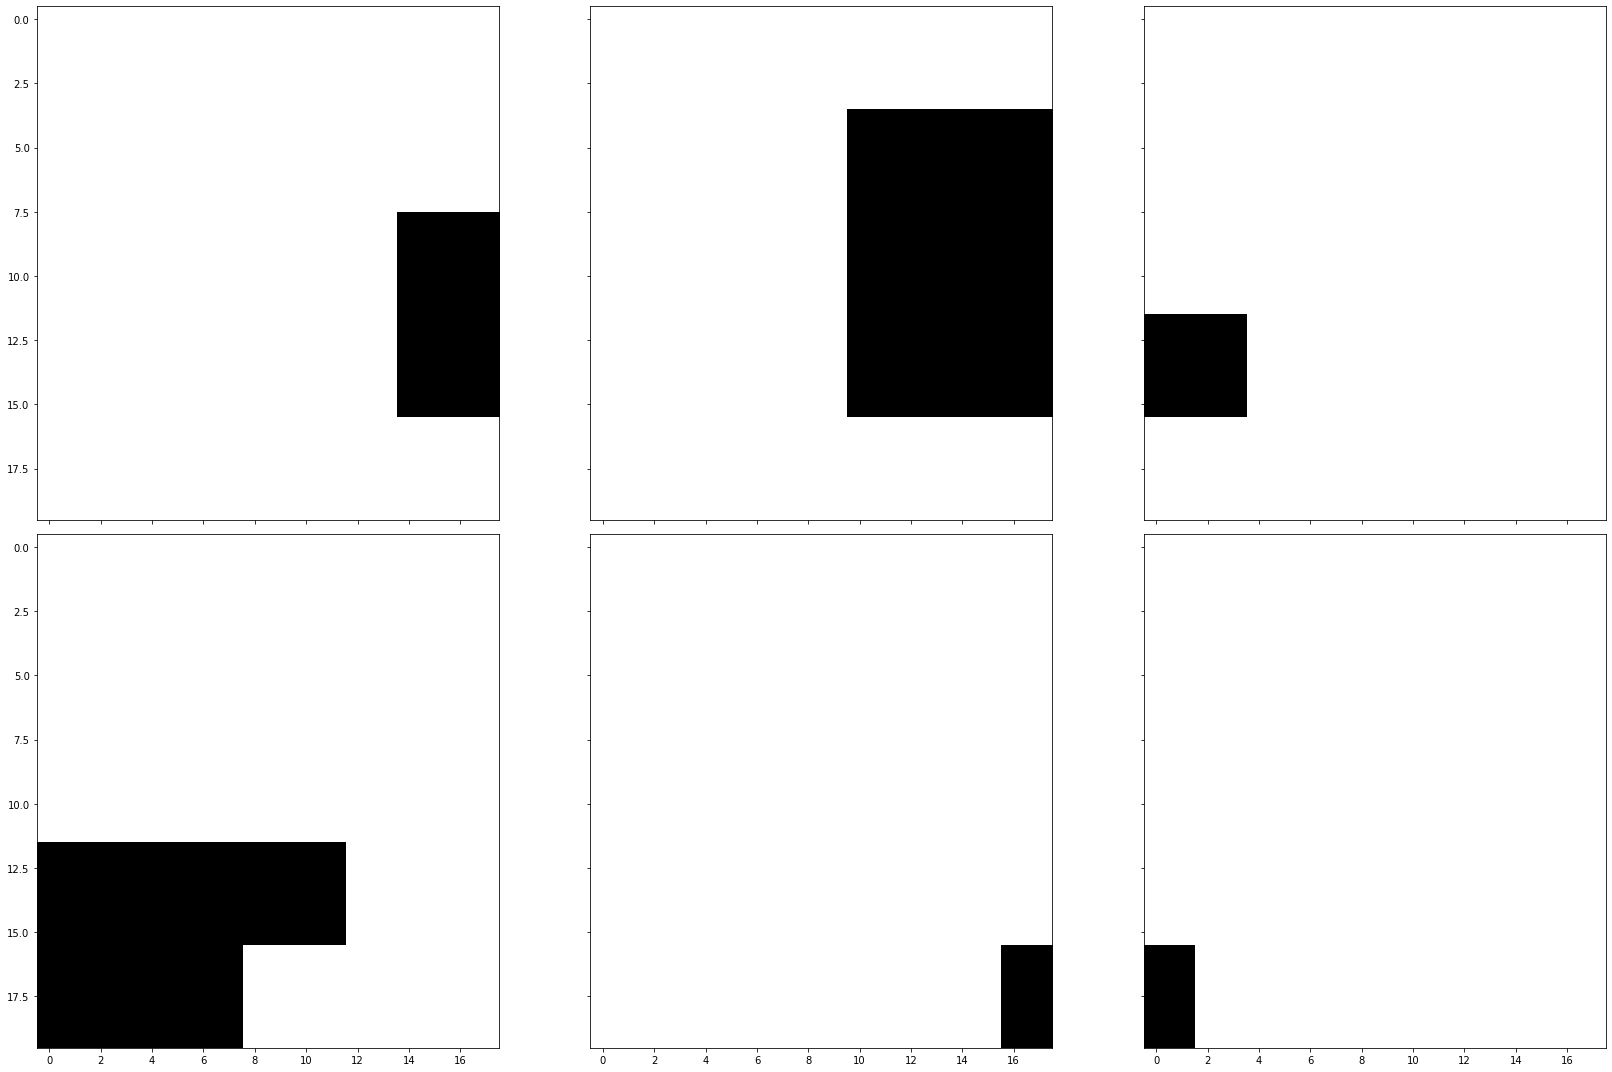

In [70]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0, 0].imshow(npPatches[0])
ax[0, 1].imshow(npPatches[1])
ax[0, 2].imshow(npPatches[2])
ax[1, 0].imshow(npPatches[3])
ax[1, 1].imshow(npPatches[4])
ax[1, 2].imshow(npPatches[5])
fig.tight_layout()

plt.show()

In [ ]:
#extract shape features: solidity, orientation, diameter, area, eccentricity, convex area, major axis length, minor axis length, and extent

In [ ]:
#extract MR8 texture features: 36 bar and edge filters, a Gaussian filter, and a Laplacian of Gaussian filter. The eight highest responses are extracted to maintain rotation invariance. 

In [ ]:
#extract HoG feature

In [ ]:
feature_names = ['solidity', 'orientation', 'diameter', 'area', 'eccentricity', 'convex area', 'major axis length', 
                 'minor axis length', 'extent', 'hog']
#include texture features
labels = [0, 1]

In [ ]:
#features are numeric values, the vector created by combining/concatenating these values is the X data
#this vector is created for each patch, and paired with a label to create the dataset

In [ ]:
clf = svm.LinearSVC()

#clf.fit(X_train, y_train)

#Predict the response for test dataset
#y_pred = clf.predict(X_test)

In [ ]:
#this classifier is going to give a prediction for each patch, 
#so to get the total number of positive cells in an image we will need to sum the label values of the patches